In [24]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 1000
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV, StratifiedGroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
import pickle
import os

In [25]:
df = pd.read_csv("../data/final_dataset_responder.csv")
df.head()

,participants_ID,DISC/REP,indication,formal_status,Dataset,Consent,sessSeason,sessTime,Responder,Remitter,...,ever_used_cigarette,hours_since_last_cigarette,ever_used_coffee,hours_since_last_coffee,ever_used_beer,hours_since_last_beer,ever_used_drugs,hours_since_last_drugs,hours_since_last_meal,hours_since_last_sleep
0,sub-87999321,DISCOVERY,MDD,MDD,MDD-rTMS,YES,spring,NaN,1,1.0,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,5.0,7.0
1,sub-88000181,DISCOVERY,MDD,MDD,MDD-rTMS,YES,summer,NaN,0,0.0,...,0.0,NaN,1.0,9.0,1.0,15.0,1.0,0.0,3.0,7.0
2,sub-88000313,DISCOVERY,MDD,MDD,MDD-rTMS,YES,summer,NaN,1,1.0,...,1.0,9.0,1.0,9.0,0.0,NaN,1.0,0.0,3.0,9.0
3,sub-88000489,DISCOVERY,MDD,MDD,MDD-rTMS,YES,summer,NaN,1,1.0,...,0.0,NaN,1.0,5.0,1.0,13.0,1.0,0.0,5.0,9.0
4,sub-88000533,DISCOVERY,MDD,MDD,MDD-rTMS,YES,summer,NaN,1,1.0,...,1.0,8.0,1.0,9.0,1.0,13.0,1.0,0.0,3.0,5.0


In [26]:
missing_counts = df.isnull().sum()
missing_counts_sorted = missing_counts.sort_values() # sort
print(missing_counts_sorted)

print("Row missing age:", df[df["age"].isna()].index)
print("Row missing indication:", df[df["indication"].isna()].index)
print("Row missing hearing:", df[df["hearing"].isna()].index)
print("Row missing well:", df[df["well"].isna()].index)

participants_ID                 0
n_oddb_FP                       0
n_oddb_CN                       0
n_oddb_FN                       0
EO                              0
EC                              0
nrSessions                      0
sessID                          0
n_oddb_CP                       0
gender                          0
Responder                       0
sessSeason                      0
Consent                         0
Dataset                         0
DISC/REP                        0
hearing                         1
ever_used_coffee                1
vision                          1
well                            1
education                       1
ever_used_beer                  1
ever_used_drugs                 1
ever_used_cigarette             1
hours_since_last_meal           1
hours_since_last_sleep          1
indication                      1
age                             1
Remitter                        4
avg_rt_oddb_CP                  4
neoFFI_q10    

In [27]:
duplicate_ids = df["participants_ID"].value_counts()
duplicate_ids = duplicate_ids[duplicate_ids > 1].index

print(df[df["participants_ID"].isin(duplicate_ids)])

# TO DO: may need to handle group structure in data

    participants_ID   DISC/REP indication formal_status   Dataset Consent  \
12     sub-88006161  DISCOVERY        MDD           MDD  MDD-rTMS     YES   
13     sub-88006161  DISCOVERY        MDD           MDD  MDD-rTMS     YES   
18     sub-88009901  DISCOVERY        MDD           MDD  MDD-rTMS     YES   
19     sub-88009901  DISCOVERY        MDD           MDD  MDD-rTMS     YES   
24     sub-88010981  DISCOVERY        MDD           MDD  MDD-rTMS     YES   
25     sub-88010981  DISCOVERY        MDD           MDD  MDD-rTMS     YES   
29     sub-88012461  DISCOVERY        MDD           MDD  MDD-rTMS     YES   
30     sub-88012461  DISCOVERY        MDD           MDD  MDD-rTMS     YES   
35     sub-88015117  DISCOVERY       ADHD          ADHD   ADHD_NF     YES   
36     sub-88015117  DISCOVERY       ADHD           NaN   ADHD_NF     YES   
38     sub-88017409  DISCOVERY        MDD           MDD  MDD-rTMS     YES   
39     sub-88017409  DISCOVERY        MDD           MDD  MDD-rTMS     YES   

In [28]:
# remove non-predictive columns
participants_ids = df['participants_ID']
df = df.drop(columns=['participants_ID','Dataset','sessID','sessSeason','nrSessions','sessTime'])
df = df.drop(columns=['Consent','DISC/REP','EC','EO']) # one unique val across all participants
df = df.drop(columns=['vision','hearing']) # only has unique vals 0 or missing
# remove columns that would cause data leakage
df = df.drop(columns=['Remitter','BDI_post','YBOCS_post','ADHD_post_Att_leading','ADHD_post_Hyp_leading'])
# pull out target variable: Remitter
y = df['Responder']
df = df.drop(columns=['Responder'])

## First try: use columns with few missing values (<=5)

In [29]:
X_few_missing = df.loc[:, df.isna().sum() <= 5]
X_few_missing = X_few_missing.copy()

# binary vars float --> str
X_few_missing['gender'] = X_few_missing['gender'].map({1.0: 'male', 0.0: 'female'})
binary_cols = ['ever_used_cigarette', 'ever_used_coffee', 'ever_used_beer', 'ever_used_drugs']
for col in binary_cols:
    X_few_missing[col] = X_few_missing[col].map({1.0: 'yes', 0.0: 'no'})

print(X_few_missing.shape)
print(X_few_missing.columns)
X_few_missing.head()

(230, 16)
Index(['indication', 'age', 'gender', 'avg_rt_oddb_CP', 'n_oddb_CP',
       'n_oddb_FP', 'n_oddb_CN', 'n_oddb_FN', 'education', 'well',
       'ever_used_cigarette', 'ever_used_coffee', 'ever_used_beer',
       'ever_used_drugs', 'hours_since_last_meal', 'hours_since_last_sleep'],
      dtype='object')


,indication,age,gender,avg_rt_oddb_CP,n_oddb_CP,n_oddb_FP,n_oddb_CN,n_oddb_FN,education,well,ever_used_cigarette,ever_used_coffee,ever_used_beer,ever_used_drugs,hours_since_last_meal,hours_since_last_sleep
0,MDD,49.66,male,0.261,60,0,280,0,18.0,1.0,no,no,no,yes,5.0,7.0
1,MDD,45.99,female,0.306,60,0,280,0,11.0,-2.0,no,yes,yes,yes,3.0,7.0
2,MDD,35.38,female,0.291,60,0,280,0,17.0,1.0,yes,yes,no,yes,3.0,9.0
3,MDD,42.36,male,0.319,59,0,280,1,18.0,1.0,no,yes,yes,yes,5.0,9.0
4,MDD,45.14,female,0.458,60,0,280,0,17.0,1.0,yes,yes,yes,yes,3.0,5.0


In [30]:
# construct preprocesser
# decide which encoder to use on each feature
onehot_ftrs = ['indication','gender','ever_used_cigarette','ever_used_coffee','ever_used_beer','ever_used_drugs']
ordinal_ftrs = ['well']
ordinal_cats = [[-2, -1, 0, 1, 2, 3]]
std_ftrs = ['age','avg_rt_oddb_CP','n_oddb_CP','n_oddb_FP','n_oddb_CN','n_oddb_FN','education','hours_since_last_meal','hours_since_last_sleep']

# one hot pipeline = just fill nan with 'missing'
onehot_transformer = Pipeline(steps=[
    ('imputer0', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

# ordinal pipeline
ordinal_transformer = Pipeline(steps=[
    ('imputer1', SimpleImputer(strategy='constant',fill_value=1)), # fills missing values with 1 = normal
    ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
    ('scaler', StandardScaler()) 
])

# numeric pipeline with imputation + scaling
numeric_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='median')),  # fills missing values with median
    ('scaler', StandardScaler())                    # scales features
])

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_ftrs), 
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('std', numeric_transformer, std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

In [31]:
# outer split - separate holdout test set
# gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# train_val_idx, test_idx = next(gss.split(X_few_missing, y, groups=participants_ids))

# X_train_val = X_few_missing.iloc[train_val_idx]
# y_train_val = y.iloc[train_val_idx]
# groups_train_val = participants_ids.iloc[train_val_idx]

# X_test = X_few_missing.iloc[test_idx]
# y_test = y.iloc[test_idx]

# print(X_train_val.shape)
# print(X_test.shape)

outer_split = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42) # Outer split: split test and other

for train_val_idx, test_idx in outer_split.split(X_few_missing, y, groups=participants_ids):
    break 

X_train_val = X_few_missing.iloc[train_val_idx]
y_train_val = y.iloc[train_val_idx]
groups_train_val = participants_ids.iloc[train_val_idx]

X_test = X_few_missing.iloc[test_idx]
y_test = y.iloc[test_idx]

print(X_train_val.shape)
print(X_test.shape)

(185, 16)
(45, 16)


In [ ]:
# split data (groupkfold?)
# n_splits = 5
# gkf = GroupKFold(n_splits=n_splits)
# ids_train_val = participants_ids.iloc[train_val_idx]

# for fold, (train_idx, val_idx) in enumerate(gkf.split(X_train_val, y_train_val, groups=ids_train_val)):
#     print(f"Fold {fold+1}")
#     X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     print("X_train shape:", X_train.shape)
#     print("X_val shape:", X_val.shape)

inner_split = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)
ids_train_val = participants_ids.iloc[train_val_idx]

for fold, (train_idx, val_idx) in enumerate(inner_split.split(X_train_val, y_train_val, groups=ids_train_val)):
    print(f"Fold {fold+1}")
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)

Fold 1
X_train shape: (136, 16)
X_val shape: (49, 16)
Fold 2
X_train shape: (141, 16)
X_val shape: (44, 16)
Fold 3
X_train shape: (138, 16)
X_val shape: (47, 16)
Fold 4
X_train shape: (140, 16)
X_val shape: (45, 16)


In [33]:
# try preprocessor on the last fold
print("Before preprocessing...")
print("X train:", X_train.shape)
print("X val:", X_val.shape)
print("X test:", X_test.shape, "\n")

X_train_prep = clf.fit_transform(X_train)

# relabel the columns after transformation
onehot_feature_names = clf.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out()
new_feature_names = list(onehot_feature_names) + ordinal_ftrs + std_ftrs
print(new_feature_names)

X_train_prep = pd.DataFrame(X_train_prep, columns=new_feature_names)
X_val_prep = pd.DataFrame(clf.transform(X_val), columns=new_feature_names)
X_test_prep = pd.DataFrame(clf.transform(X_test), columns=new_feature_names)

# print number of data points after preprocessing
print("After preprocessing...")
print("X train:", X_train_prep.shape)
print("X val:", X_val_prep.shape)
print("X test:", X_test_prep.shape)

Before preprocessing...
X train: (140, 16)
X val: (45, 16)
X test: (45, 16) 

['indication_ADHD', 'indication_ADHD/OCD', 'indication_MDD', 'indication_MDD/OCD', 'indication_MDD/PAIN', 'indication_MDD/bipolar', 'indication_OCD', 'indication_OCD/ASD', 'indication_OCD/MDD', 'indication_missing', 'gender_female', 'gender_male', 'ever_used_cigarette_no', 'ever_used_cigarette_yes', 'ever_used_coffee_no', 'ever_used_coffee_yes', 'ever_used_beer_no', 'ever_used_beer_yes', 'ever_used_drugs_no', 'ever_used_drugs_yes', 'well', 'age', 'avg_rt_oddb_CP', 'n_oddb_CP', 'n_oddb_FP', 'n_oddb_CN', 'n_oddb_FN', 'education', 'hours_since_last_meal', 'hours_since_last_sleep']
After preprocessing...
X train: (140, 30)
X val: (45, 30)
X test: (45, 30)


In [ ]:
log_reg = LogisticRegression(solver='saga', max_iter=100000000)
log_reg.fit(X_train_prep, y_train)
y_pred_val = log_reg.predict(X_val_prep)
y_pred_train = log_reg.predict(X_train_prep)
print("Accuracy on validation set:", accuracy_score(y_val,y_pred_val))
print("Accuracy on training set:", accuracy_score(y_train,y_pred_train))

Accuracy on validation set: 0.6888888888888889
Accuracy on training set: 0.7214285714285714


In [35]:
svc = SVC(kernel='rbf', C=1.0, gamma='scale')
svc.fit(X_train_prep, y_train)
y_pred_val = svc.predict(X_val_prep)
y_pred_train = svc.predict(X_train_prep)
print("Accuracy on validation set:", accuracy_score(y_val,y_pred_val))
print("Accuracy on training set:", accuracy_score(y_train,y_pred_train))

Accuracy on validation set: 0.7333333333333333
Accuracy on training set: 0.7142857142857143


In [ ]:
def MLpipe_SGKFold(X, y, group_ids, preprocessor, ML_algo, param_grid, model_name, eval_metric):
    '''
    Pipeline with:
        Splitting method -- StratifiedGroupKFold
        Evaluation metric -- Depends on input
    '''

    test_scores = []
    best_models = []

    num_states = 10

    for i in range(num_states):
        # Define random state
        random_state = 29*i
        print(f"---Running random state {random_state}---")

        # ---SPLIT---
        outer_split = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state) # Outer split: split test and other

        for other_idx, test_idx in outer_split.split(X, y, groups=group_ids):
            break # Break after the first split to separate out the test set for this state
        
        X_other = X.iloc[other_idx]
        y_other = y.iloc[other_idx]
        subject_ids_other = group_ids.iloc[other_idx] 
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]

        kf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=random_state) # Inner split: 4 fold CV

        # ---PREPROCESS---
        # Main preprocessor is fed into function in "preprocessor"
        final_scaler = StandardScaler()

        # ---CONSTRUCT PIPELINE & GRID SEARCH---
        pipeline = make_pipeline(preprocessor, ML_algo)

        if eval_metric == "accuracy":
            grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='accuracy', return_train_score=True, n_jobs=-1, verbose=True)
        elif eval_metric == "precision":
            grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='precision_macro', return_train_score=True, n_jobs=-1, verbose=True)
        elif eval_metric == "f1_macro":
            grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='f1_macro', return_train_score=True, n_jobs=-1, verbose=True)
        elif eval_metric == "f1_weighted":
            grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='f1_weighted', return_train_score=True, n_jobs=-1, verbose=True)
        else:
            raise ValueError("Evaluation metric not handled in this pipeline.")
        
        grid.fit(X_other, y_other, groups=subject_ids_other)

        results = pd.DataFrame(grid.cv_results_)
        # print("\nGrid search results:\n", results)

        # ---SAVE BEST MODEL PER RANDOM STATE PER MODEL---
        best_model = grid.best_estimator_
        best_models.append(best_model)
        print('Best model parameters:', grid.best_params_)
        y_test_pred = best_model.predict(X_test)

        if eval_metric == "accuracy":
            best_test_score = accuracy_score(y_test, y_test_pred)
        elif eval_metric == "precision":
            best_test_score = precision_score(y_test, y_test_pred, average="macro")
        elif eval_metric == "f1_macro":
            best_test_score = f1_score(y_test, y_test_pred, average="macro")
        elif eval_metric == "f1_weighted":
            best_test_score = f1_score(y_test, y_test_pred, average="weighted")
        else:
            raise ValueError("Evaluation metric not handled in this pipeline.")
            
        test_scores.append(best_test_score)
        print(f"Test score for random state {29*i}: {best_test_score:.4f}")
        
    # ---SAVE ALL BEST MODELS AND TEST SCORES PER MODEL IN RESULTS---
    file_path = os.path.join('../results/', f'{model_name}_{eval_metric}_responder.save')
    with open(file_path, 'wb') as file:
        pickle.dump((best_models, test_scores), file)

    return test_scores, best_models

In [37]:
# test pipeline on simple logistic regression model first
log_reg = LogisticRegression(solver='saga', max_iter=100000000)
param_grid = {} 
log_reg_test_scores, log_reg_best_models = MLpipe_SGKFold(X_few_missing, y, participants_ids, preprocessor, log_reg, param_grid, "Test_SimpleLogisticRegression", "accuracy")

---Running random state 0---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 0: 0.7333
---Running random state 29---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 29: 0.7609
---Running random state 58---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 58: 0.6889
---Running random state 87---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 87: 0.7660
---Running random state 116---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 116: 0.5778
---Running random state 145---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 145: 0.7174
---Running random state 174---
Fitting 4 folds for each of 1 candidates, t

In [38]:
# define model algorithms and parameter grids
models = {
    'SimpleLogisticRegression': (
        LogisticRegression(solver='saga', max_iter=1000000), {} 
    ),
    'L1LogisticRegression': (
        LogisticRegression(penalty='l1', solver='saga', max_iter=1000000),
        {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
    ),
    'L2LogisticRegression': (
        LogisticRegression(penalty='l2', solver='saga', max_iter=1000000),
        {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
    ),
    'ElasticNet': (
        LogisticRegression(penalty='elasticnet', solver='saga', max_iter=100000000),
        {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
         'logisticregression__l1_ratio': [0.001, 0.01, 0.1, 1]}
    ),
    'RandomForestClassifier': (
        RandomForestClassifier(random_state=42),
        {'randomforestclassifier__n_estimators': [100],
         'randomforestclassifier__max_depth': [1, 3, 5, 10, 20, 100],
         'randomforestclassifier__max_features': [0.25, 0.5, 0.75, 1.0, None]}
    ),
    'SupportVectorClassifier': (
        SVC(probability=True),
        {'svc__C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
         'svc__gamma': [1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5]}
    ),
}

In [39]:
# # evaluation metric = accuracy
# summary_acc = {}
# for model_name, (algo, param_grid) in models.items():
#     print(f"\nTraining {model_name}...")
#     test_scores, best_models = MLpipe_SGKFold(X_few_missing, y, participants_ids, preprocessor, algo, param_grid, model_name, "accuracy")
#     mean_score = np.mean(test_scores)
#     stddev_score = np.std(test_scores)
#     print("Test Accuracy Scores:", test_scores)
#     print(f"Mean Test Accuracy: {mean_score:.4f}")
#     print(f"Std Dev of Test Accuracy: {stddev_score:.4f}")
#     summary_acc[model_name] = (mean_score, stddev_score)

# # display the summary
# print("\nSummary of Results:")
# for model_name, (mean_score, stddev_score) in summary_acc.items():
#     print(f"{model_name}: Mean Accuracy = {mean_score:.4f}, Std Dev = {stddev_score:.4f}")

## Second try: test out fewer variables

In [40]:
X_second = df[['age','gender','education']]
X_second = X_second.copy()

# binary vars float --> str
X_second['gender'] = X_second['gender'].map({1.0: 'male', 0.0: 'female'})

print(X_second.shape)
print(X_second.columns)
X_second.head()

(230, 3)
Index(['age', 'gender', 'education'], dtype='object')


,age,gender,education
0,49.66,male,18.0
1,45.99,female,11.0
2,35.38,female,17.0
3,42.36,male,18.0
4,45.14,female,17.0


In [41]:
# construct preprocesser
# decide which encoder to use on each feature
onehot_ftrs = ['gender']
std_ftrs = ['age','education']

# one hot pipeline = just fill nan with 'missing'
onehot_transformer = Pipeline(steps=[
    ('imputer0', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

# numeric pipeline with imputation + scaling
numeric_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='median')),  # fills missing values with median
    ('scaler', StandardScaler())                    # scales features
])

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_ftrs), 
        ('std', numeric_transformer, std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

In [42]:
# evaluation metric = accuracy
summary_acc = {}
for model_name, (algo, param_grid) in models.items():
    print(f"\nTraining {model_name}...")
    test_scores, best_models = MLpipe_SGKFold(X_few_missing, y, participants_ids, preprocessor, algo, param_grid, model_name, "accuracy")
    mean_score = np.mean(test_scores)
    stddev_score = np.std(test_scores)
    print("Test Accuracy Scores:", test_scores)
    print(f"Mean Test Accuracy: {mean_score:.4f}")
    print(f"Std Dev of Test Accuracy: {stddev_score:.4f}")
    summary_acc[model_name] = (mean_score, stddev_score)

# display the summary
print("\nSummary of Results:")
for model_name, (mean_score, stddev_score) in summary_acc.items():
    print(f"{model_name}: Mean Accuracy = {mean_score:.4f}, Std Dev = {stddev_score:.4f}")


Training SimpleLogisticRegression...
---Running random state 0---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 0: 0.7556
---Running random state 29---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 29: 0.7826
---Running random state 58---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 58: 0.7556
---Running random state 87---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 87: 0.7447
---Running random state 116---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 116: 0.6444
---Running random state 145---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 145: 0.7609
---Running random state 174---
Fitti

In [43]:
# Summary of Results:
# SimpleLogisticRegression: Mean Accuracy = 0.7380, Std Dev = 0.0595
# L1LogisticRegression: Mean Accuracy = 0.7335, Std Dev = 0.0629
# L2LogisticRegression: Mean Accuracy = 0.7334, Std Dev = 0.0683
# ElasticNet: Mean Accuracy = 0.7355, Std Dev = 0.0683
# RandomForestClassifier: Mean Accuracy = 0.7379, Std Dev = 0.0694
# SupportVectorClassifier: Mean Accuracy = 0.7180, Std Dev = 0.0783

In [44]:
file = open('../results/SimpleLogisticRegression_accuracy_responder.save', 'rb')
best_models, test_scores = pickle.load(file)
file.close()

# get best model
top_one_index = np.argsort(test_scores)[-1:][0]  
best_model = best_models[top_one_index]
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer0',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender']),
                                                 ('std',
                                                  Pipeline(steps=[('imputer2',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000000, solver='saga'))])

LogisticRegression(max_iter=1000000, solver='saga')


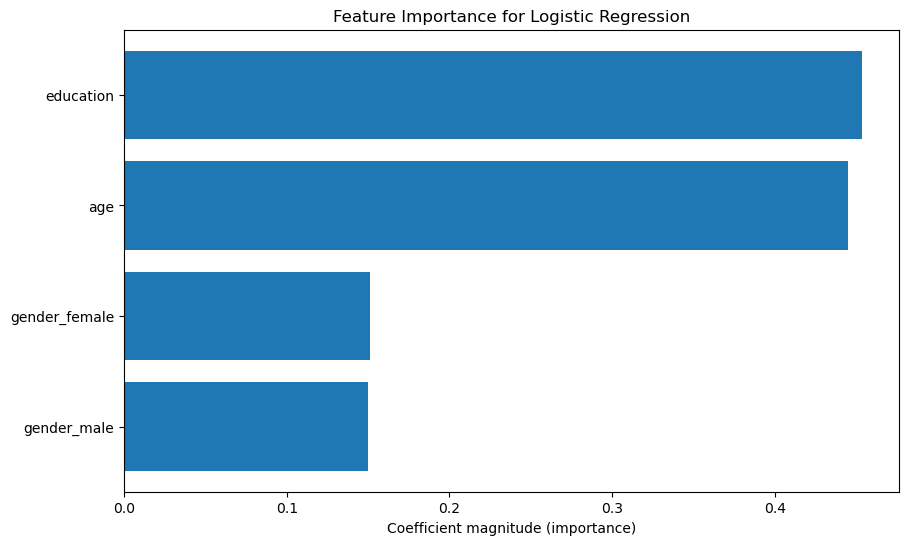

In [45]:
log_reg_model = best_model.named_steps['logisticregression']
print(log_reg_model)

# get the preprocessed feature names
preprocessor = best_model.named_steps['columntransformer']
onehot_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out()
numeric_columns = std_ftrs
feature_names = np.concatenate([onehot_columns, numeric_columns])

# get coefficients
coefs = log_reg_model.coef_[0]  # binary classification

# Put in dataframe
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefs),
    'coef': coefs
}).sort_values(by='importance', ascending=False)

# plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Coefficient magnitude (importance)')
plt.title('Feature Importance for Logistic Regression')
plt.show()